<a href="https://colab.research.google.com/github/fabiodr/colabs/blob/main/Synthesizer_in_DSPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

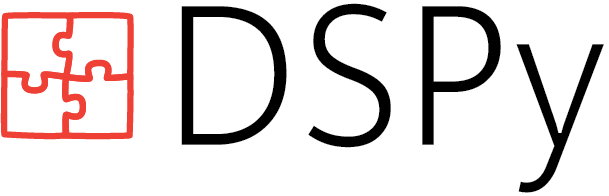

Often times it happens that we think of a task to solve but when we start we either have less data(<10 examples) or we have no data at all. In both cases, one would either give up on the task or spend a good chunk of time curating data for it, be it for optimizing DSPy pipelines or evaluating them.

But what if we could generate more data by giving whatever small amount of data we have or what if we could generate more data by merely giving the layout of the task a.k.a. `dspy.Signature`. This is what `Synthesizer` aims to solve, to generate diverse quality synthetic data based on DSPy Signature or few examples of how dataset should be like,

`Synthesizer` also provides you options to steer you generations in the optimal direction like:

* Feedback driven generation(Automated feedback and Human in a loop Feedback)
* Example driven generation(For improve variance in generation)
* Option to use different LM for input and output data generation

With just a few lines of code you can generated hundreds and thousands of more datapoints!! Let's see how...

## Setting Up

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab
    repo_path = 'dspy'
    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)

# Set up the cache for this notebook
os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(repo_path, 'cache')

import pkg_resources # Install the package if it's not installed
if not "dspy-ai" in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    # !pip install dspy-ai
    !pip install -e $repo_path

fatal: cannot change to 'dspy': No such file or directory
Cloning into 'dspy'...
remote: Enumerating objects: 27221, done.
remote: Counting objects: 100% (4294/4294), done.
remote: Compressing objects: 100% (1366/1366), done.
remote: Total 27221 (delta 3244), reused 3514 (delta 2892), pack-reused 22927
Receiving objects: 100% (27221/27221), 26.27 MiB | 15.66 MiB/s, done.
Resolving deltas: 100% (11679/11679), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Obtaining file:///content/dspy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 6.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versio

In [ ]:
import dsp
import dspy
import openai

from dspy.datasets import DataLoader
from dspy.experimental import Synthesizer, SynthesizerArguments

In [ ]:
openai.api_key = ""

turbo = dspy.OpenAI(model='gpt-3.5-turbo-0125', max_tokens=512)
dspy.settings.configure(lm=turbo)

# Synthetic Data Generation with `Synthesizer`

`Synthesizer` provides you 2 ways to ground your generations: **DSPy Signatures** and `dspy.Example`. In simple terms, you can tell the `Synthesizer` about the inputs, outputs and task of the synthetic data via these 2 ways.

## Synthetic Data Generation with Examples

One the the simplest way to generate synthetic data especially if you have some data in small amount say 3-10 examples, then you can simply pass them to the `Synthesizer` as `ground_source` argument of `generate` method. What the task is and what the inputs and outputs mean is determined by the Synthesizer.

If you pass some examples as `ground_source` you must pass it as a List of `dspy.Example` with `input_keys` set and rest you can leave upto `Synthesizer` to infer.

In [ ]:
from dspy.datasets import DataLoader
from dspy.experimental import Synthesizer, SynthesizerArguments

dl = DataLoader()

gsm8k_data = dl.from_huggingface(
    "gsm8k", "main",
    fields=("question", "answer"),
    input_keys=("question",),
    split="train[:8]"
)

config = SynthesizerArguments()
synthesizer = Synthesizer(config=config)

synthesizer.generate(
    ground_source=gsm8k_data,
    num_data=10,
    batch_size=2,
)

## Synthetic Data Generation with `dspy.Signature`

One of the most convinient way to generate synthetic data is by passing the signature as `ground_source`. If you are working in DSPy you will have atleast the `dspy.Signature` of the task you are solving.

All you gotta do is pass it as argument and relax. You can improve the generations by passing the `desc` of each field and explaining it in depth but if you don't want to `Synthesizer` will do it for you.

In [ ]:
class GenerateAnswer(dspy.Signature):
    """Answer questions with short factoid answers."""

    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

config = SynthesizerArguments()
synthesizer = Synthesizer(config=config)

syn_data = synthesizer.generate(
    ground_source=GenerateAnswer,
    num_data=10
)

# Optimizing Generations

There are a lot of ways in which you can improve the generations in terms of the time taken for generation as well as the quality of generated data that `Synthesizer` provides you out of the box.

## Batch Generations

If you want a slight improvement with latency without compromising on the model you are using for generation is via batch generations which lets the LLM generate the data in batches. If improves the latency a bit but sometimes compromises the data variance with weaker LLMs.

In [ ]:
config = SynthesizerArguments()
synthesizer = Synthesizer(config=config)

synthesizer.generate(
    ground_source=gsm8k_data,
    num_data=10,
    batch_size=2,
)

## Feedback Driven Generation

Synthesizer in itself is great at figuring out the nature of dataset and it's corresponding fields. However, you can make the generations even better by passing feedback for first **n** generations yourself. This **n** is set by passing `num_example_for_feedback` in config.

`Synthesizer` provides 2 modes of feedback:

* `human`: You see the generation and provide feedback yourself.
* `llm`: LLM gives the feedback by critisizing the generation if needed.

`Synthesizer` takes these feedback and modifies it's generation signatures to improve the generation and currently my go to method for generation.

In [ ]:
config = SynthesizerArguments(
    feedback_mode="human",
    num_example_for_feedback=3,
)
synthesizer = Synthesizer(config=config)

syn_data = synthesizer.generate(
    ground_source=GenerateAnswer,
    num_data=10
)

## Example Driven Generation

You can improve the diversity of the generation by letting `Synthesizer` use the examples as few shot example for generating data for input fields. While this improves diversity of the output it also increases the cost of generations too!

In [ ]:
config = SynthesizerArguments(
    num_example_for_optim=2
)

synthesizer = Synthesizer(config=config)

syn_data = synthesizer.generate(
    ground_source=gsm8k_data,
    num_data=10
)

## Teacher Based Output Generation

`Synthesizer` creates a simple Signature that helps generating labels for the synthetic data however you can pass your own DSPy Pipelines to labels the inputs for improved output data generation.

In [ ]:
config = SynthesizerArguments(
    output_teacher_module=GSM8KTeacherModule(),
)

synthesizer = Synthesizer(config=config)

syn_data = synthesizer.generate(
    ground_source=gsm8k_data,
    num_data=10
)

# Cost Management Tips

## Managing LM for Different Pipelines

`Synthesizer` generates input and output data seperately and it also lets you choose the LLM to use for generation in both. So you can as it to generate input data via a weaker LLM but the output via a stronger LLM like GPT-4.

This way you can avoid using a stronger LLMs if you don't want to.

In [ ]:
config = SynthesizerArguments(
    input_lm_model=turbo,
    output_lm_model=dspy.OpenAI(model='gpt-4-turbo-preview', max_tokens=512)
)

synthesizer = Synthesizer(config=config)

syn_data = synthesizer.generate(
    ground_source=GenerateAnswer,
    num_data=10
)